## Подготовка данных

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

In [2]:
df = pd.read_csv("https://storage.yandexcloud.net/auth-def-2024/datasets/meta_table_with_texts.csv")

In [3]:
df = df[['author', 'text']]
df.head(5)

author  \
0        Пушкин Александр Сергеевич   
1       Карамзин Николай Михайлович   
2         Гоголь Николай Васильевич   
3  Мамин-Сибиряк Дмитрий Наркисович   
4  Мамин-Сибиряк Дмитрий Наркисович   

                                                text  
0  \n   \nЛитературный альбомъ.\n"Сраженный рыцар...  
1  \nО достоинстве древних и новых\n(Перевод с не...  
2  \n   Гоголь Н. В. Полное собрание сочинений и ...  
3  \n   \nД. МАМИНЪ-СИБИРЯКЪПОЛНОЕ СОБРАНІЕ СОЧИН...  
4  \nДмитрий Мамин-Сибиряк\nНимфа\nI.\n   Щегольс...

### Расчет эвристик

*Примечание: в ходе расчетов могут дублироваться функции обработки текста, разработанные на этапе EDA.<br>*
Прежде, чем рассчитывать эвристики, почистим текст от нежелательных пробельных символов, а также некорректных unicode-символов:

In [4]:
import re

def clean_df(x):
  # Удаление unicode-символов
  x = re.sub(r'&#\d+;|&#x[0-9a-fA-F]+;', '', x)
  x = x.replace('\n', ' ')
  v2 = re.sub(r'[^А-Яа-я0-9\(\).,!?: \-]', '', x.lower())
  result = re.sub(r'\s+', ' ', v2).strip()
  return result

In [5]:
df['clean_text'] = df['text'].apply(clean_df)

In [6]:
df.head(5)

author  \
0        Пушкин Александр Сергеевич   
1       Карамзин Николай Михайлович   
2         Гоголь Николай Васильевич   
3  Мамин-Сибиряк Дмитрий Наркисович   
4  Мамин-Сибиряк Дмитрий Наркисович   

                                                text  \
0  \n   \nЛитературный альбомъ.\n"Сраженный рыцар...   
1  \nО достоинстве древних и новых\n(Перевод с не...   
2  \n   Гоголь Н. В. Полное собрание сочинений и ...   
3  \n   \nД. МАМИНЪ-СИБИРЯКЪПОЛНОЕ СОБРАНІЕ СОЧИН...   
4  \nДмитрий Мамин-Сибиряк\nНимфа\nI.\n   Щегольс...   

                                          clean_text  
0  литературный альбомъ. сраженный рыцарь. пушкин...  
1  о достоинстве древних и новых (перевод с немец...  
2  гоголь н. в. полное собрание сочинений и писем...  
3  д. маминъ-сибирякъполное собране сочиненйтомъ ...  
4  дмитрий мамин-сибиряк нимфа . щегольской волжс...

В некоторых текстах все еще встречаются сомнительные слова, которые содержат в себе цифры (номера страниц). Поэтому дополнительно проведем очистку таких слов, чтобы цифры исчезли. Эта функция допонительно уберет даты и прочие числа.

In [12]:
# Функция очистки слов, содержащих цифры
def remove_digits_from_words(text):
    return ' '.join(
        re.sub(r'\d+', '', word) if re.search(r'[a-zA-Zа-яА-Я]', word) and re.search(r'\d', word) else word
        for word in text.split()
    )

In [17]:
df['clean_text'] = df['clean_text'].apply(remove_digits_from_words)

#### Lexicon-based эвристики

Начнем с **Lexicon-based** для определения тональности и субъективности текста.

In [ ]:
from textblob import TextBlob

# Тональность текста
df['tonality'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Субъективность текста
df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Также рассмотрим вероятность токстичности текста с помощью предобученной модели `unitary/toxic-bert`:

In [ ]:
from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
toxicity_model = pipeline("text-classification", model="unitary/toxic-bert", tokenizer="unitary/toxic-bert")

# Функция для сокращения текста в случае превышения лимита токенов (512)
# Исключаем специальные токены [CLS] и [SEP]
def truncate_text(text, max_length=510):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length]
    return tokenizer.convert_tokens_to_string(truncated_tokens)

# Функция вычисления токсичности текста
def predict_toxicity(text):
    result = toxicity_model(text)
    return result[0]['score'] if result[0]['label'] == "LABEL_1" else 0


df['toxicity_score'] = df['clean_text'].apply(lambda x: predict_toxicity(truncate_text(x)))

In [ ]:
df[df['toxicity_score'] != 0]

In [ ]:
df = df.drop('toxicity_score', axis = 1)

Как видим, в нашем датасете не было выявлено токсичности, поэтому данный признак не имеет смысла рассматривать в модели.

Мы вычислим в качестве стилистических эвристик средние значения для каждого автора, чтобы избежать шумов в рамках отдельных текстов и упростить анализ. Это связано с тем, что такие признаки, как тональность и субъективночть лучше обобщать, группируя по авторам.

In [ ]:
lexicon_based = df.groupby('author')[['tonality', 'subjectivity']].mean().reset_index()
lexicon_based.columns = ['author', 'avg_tonality', 'avg_subjectivity']
lexicon_based

In [ ]:
df = df.merge(lexicon_based, on='author', how='left')

#### Rule-based эвристики

Теперь посчитаем **Rule-based** эвристики, начнем с определения сложности текстов.

In [ ]:
!pip install textstat

In [ ]:
import textstat

# Оценка сложности текста
df['complexity'] = df['clean_text'].apply(textstat.flesch_reading_ease)

Также рассчитаем ряд числовых признаков:

In [ ]:
def avg_and_total_words(text):
    # Разделение текста на предложения
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Подсчёт слов в тексте
    words = re.findall(r'\b\w+\b', text)
    total_words = len(words)

    # Подсчёт слов в каждом предложении
    words_per_sentence = [len(re.findall(r'\b\w+\b', sentence)) for sentence in sentences]

    # Среднее количество слов в предложении
    avg_words = sum(words_per_sentence) / len(sentences) if sentences else 0

    return total_words, avg_words

In [ ]:
# Длина текста
df['len_symbols'] = df['clean_text'].apply(len)
# Общее кол-во слов/ среднее кол-во слов в предложении
df[['total_words', 'avg_words_per_sentence']] = df['clean_text'].apply(lambda x: pd.Series(avg_and_total_words(x)))

In [ ]:
df['total_words'] = df['total_words'].apply(int)

#### Корреляционная матрица

После расчета эвристик следует убедиться, что между ними не присутствует сильной заивисимости во избежание проблемы мультиколлинеарности. Построим тепловую карту для наглядности:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


heuristics = ['avg_tonality', 'avg_subjectivity', 'complexity', 'len_symbols', 'total_words', 'avg_words_per_sentence']
df_heuristics = df[heuristics]

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(df_heuristics.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица эвристик')
plt.show()

Мы видим, что между `len_symbols` и `total_words` наблюдается полная прямая зависимость, оба признака характеризуют размер текста. Оставим `total_words`, так как признак является более интерпретируемым.<br>
Высокая обратная зависимость наблюдается между `avg_words_per_sentence` и `complexity`. Чем меньше слов в предложении, тем выше значение `complexity`, а значит текст читается проще. Оставим признак `avg_words_per_sentence`, так как он более интерпретируем.<br>
Значения корреляции в $0.59$ между `avg_tonality` и `avg_subjectivity` посчитаем допустимым (будем рассматривать условный порог в $0.7$). К тому же признаки означают достаточно разные характеристики текста, поэтому не будем их исключать из перечня эвристик.

In [ ]:
heuristics = ['avg_tonality', 'avg_subjectivity', 'total_words', 'avg_words_per_sentence']

### Подготовка выборок

Перед векторизацией необходимо лемматизировать очищенный текст, чтобы избежать кодирования форм одних и тех же слов. Дополнительно будем удалять ФИО авторов, наличие которых в тексте приводит к `target leakage`, а также любые небуквенные леммы и леммы, короче 2 символов.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

In [ ]:
!pip install pymorphy2

In [21]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [22]:
import itertools

# Список ФИО авторов, представленных в датасете
author_list = list(itertools.chain(*[author.split() for author in df.author.str.lower().unique()]))

In [23]:
CNT = 0

# Функция леммитизации текста
def lemm_text(text):
    global CNT
    # Разбиение текста на токены
    tokens = word_tokenize(text)
    # Леммы слов
    lemmas = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum()]
    # Очистка лемм
    final_lemmas = [word for word in lemmas if word not in author_list and len(word) > 2
             and not re.fullmatch(r'\d+|[^A-Za-zА-Яа-яЁё]+', word)]
    CNT += 1
    print(CNT)
    return ' '.join(final_lemmas)

In [24]:
df['lemm_text'] = df['clean_text'].apply(lemm_text)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
df.head()

author  \
0        Пушкин Александр Сергеевич   
1       Карамзин Николай Михайлович   
2         Гоголь Николай Васильевич   
3  Мамин-Сибиряк Дмитрий Наркисович   
4  Мамин-Сибиряк Дмитрий Наркисович   

                                                text  \
0  \n   \nЛитературный альбомъ.\n"Сраженный рыцар...   
1  \nО достоинстве древних и новых\n(Перевод с не...   
2  \n   Гоголь Н. В. Полное собрание сочинений и ...   
3  \n   \nД. МАМИНЪ-СИБИРЯКЪПОЛНОЕ СОБРАНІЕ СОЧИН...   
4  \nДмитрий Мамин-Сибиряк\nНимфа\nI.\n   Щегольс...   

                                          clean_text  \
0  литературный альбомъ. сраженный рыцарь. пушкин...   
1  о достоинстве древних и новых (перевод с немец...   
2  гоголь н. в. полное собрание сочинений и писем...   
3  д. маминъ-сибирякъполное собране сочиненйтомъ ...   
4  дмитрий мамин-сибиряк нимфа . щегольской волжс...   

                                        cleaned_text  \
0  литературный альбомъ. сраженный рыцарь. пушкин...   
1  о достоинстве древних и новых (перевод с немец...   
2  гоголь н. в. полное собрание сочинений и писем...   
3  д. маминъ-сибирякъполное собране сочиненйтомъ ...   
4  дмитрий мамин-сибиряк нимфа . щегольской волжс...   

                                           lemm_text  
0  литературный альбомъ сразить рыцарь послднимъ ...  
1  достоинство древний новый перевод немецкий нек...  
2  полный собрание сочинение письмо так переписка...  
3  собрана сочиненйтомъ восьмой издан марксъ петр...  
4  нимфа щегольский волжский пароход вулкан дать ...

In [101]:
df_lemm = pd.read_csv('lemm_texts.csv')

In [102]:
df_lemm[df_lemm['lemm_text'].str.contains('|'.join(author_list), case=False, na=False)]

author  \
2             Гоголь Николай Васильевич   
3      Мамин-Сибиряк Дмитрий Наркисович   
5     Салтыков-Щедрин Михаил Евграфович   
7             Куприн Александр Иванович   
8           Карамзин Николай Михайлович   
...                                 ...   
2555               Чехов Антон Павлович   
2559          Куприн Александр Иванович   
2561          Куприн Александр Иванович   
2563  Салтыков-Щедрин Михаил Евграфович   
2564              Бунин Иван Алексеевич   

                                              lemm_text  
2     полный собрание сочинение письмо так переписка...  
3     собрана сочиненйтомъ восьмой издан марксъ петр...  
5     старый кот покой воспроизводиться издание собр...  
7     королевский парк фантазия текст сверить издани...  
8     египетский происшествие письмо английский офиц...  
...                                                 ...  
2555  скучный история записка старое человек полный ...  
2559  текст сверить издание собрание сочинение том т...  
2561  звезда соломон странный маловероятный событие ...  
2563  внучка панцирный боярин роман время последний ...  
2564  безумный художник оригинал здесь электронный б...  

[1530 rows x 2 columns]

In [26]:
# Дополнительно сохранение лемматизированных текстов
df[['author', 'lemm_text']].to_csv('lemm_texts.csv', index=False)

In [28]:
df_heuristics = pd.read_csv('heuristics.csv')
df_heuristics.head(5)

avg_tonality  avg_subjectivity  total_words  avg_words_per_sentence
0      0.066585          0.229008          353               15.347826
1     -0.232829          0.358885         1008               15.750000
2     -0.010425          0.195767       196245                7.540634
3     -0.000427          0.007812         9247                8.353207
4     -0.000427          0.007812         4477                6.962675

In [29]:
# Разбиваем выборки
X_text = df['lemm_text']
X_heuristics = df_heuristics.copy()
y = df['author']

Для векторизации выберем $BoW$. Разделим выборку лемматизированного текста на $train$ и $test$. Попробуем использовать разные размеры словарей для векторайзера, а качество замерим с помощью простой модельки `MultinomialNB` и выберем наиболее оптимальный размер:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

In [33]:
# Размеры словаря для проверки
sizes = [100, 500, 1000, 5000]

In [34]:
from sklearn.naive_bayes import MultinomialNB

for size in sizes:
    # Инициализация CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=size)

    # Преобразование текстов в векторное представление
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    # Обучение модели
    model = MultinomialNB()
    model.fit(X_train_vect, y_train)

    # Предсказание и оценка качества
    y_pred = model.predict(X_test_vect)
    acc_score = accuracy_score(y_test, y_pred)
    print(f"Размер словаря: {size}, точность: {acc_score:.4f}")

Размер словаря: 100, точность: 0.4971
Размер словаря: 500, точность: 0.5770
Размер словаря: 1000, точность: 0.6160
Размер словаря: 5000, точность: 0.7524


Как мы видим, с увеличением размера словаря, увеличивается значение метрики качества. Поэтому далее будем рассматривать параметр `max_features=5000`.

In [35]:
print(X_train_vect.shape)
print(X_test_vect.shape)

(2052, 5000)
(513, 5000)


По сути есть 3 подхода к обучению моделей:
- только на эвристиках,
- только на текстовых признаках,
- комбинированный подход.

Так что на этапе обучения модели будем рассматривать все возможные подходы.

### Обучение трех разных моделей и их метрики (baseline)

#### Только эвристики

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_heuristics, y, test_size=0.2, random_state=42)

# Числовые признаки лучше стандартизировать
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import numpy as np

y_pred_random = np.random.choice(np.unique(y_test), size=len(y_test))
# Оценка точности случайного предсказания
accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Accuracy (Random Baseline): {accuracy_random:.2f}")

Accuracy (Random Baseline): 0.08


Точность случайного предсказания оказывается достаточно низкой (при повторных прогонах значение не превышало $0.09$). Поэтому по метрикам качества будет разумно сравнивать уже между обученными моделями на разных подходах к отбору признаков.

In [ ]:
# Инициализация и обучение моделей
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train_scaled, y_train)
model_logreg.fit(X_train_scaled, y_train)
model_dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test_scaled)
y_pred_logreg = model_logreg.predict(X_test_scaled)
y_pred_dt = model_dt.predict(X_test_scaled)

##### Метрики качества

###### SVC

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24]]


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       1.00      1.00      1.00        21
            Бунин Иван Алексеевич       1.00      1.00      1.00        50
        Гоголь Николай Васильевич       1.00      1.00      1.00        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       1.00      1.00      1.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       1.00      1.00      1.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       1.00      1.00      1.00        28
Салтыков-Щедрин Михаил Евграфович       1.00      1.00      1.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


###### LogisticRegression

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9005847953216374
Precision: 0.8895198263549933
Recall: 0.9005847953216374
F1 Score: 0.8919118407025997
Confusion Matrix:
 [[ 8  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0 22  0  0  0  0  0  0  0  0  0 11]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 76  0  2  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0 48  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0 20]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.62      0.38      0.47        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.56      0.58      0.57        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       1.00      0.69      0.82        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       0.89      0.97      0.93        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       0.96      0.91      0.93        53
       Пушкин Александр Сергеевич       1.00      1.00      1.00        28
Салтыков-Щедрин Михаил Евграфович       1.00      1.00      1.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###### DecisionTreeClassifier

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7485380116959064
Precision: 0.6800870353271091
Recall: 0.7485380116959064
F1 Score: 0.6965201375213945
Confusion Matrix:
 [[ 0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.24      1.00      0.38        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       0.00      0.00      0.00        28
Салтыков-Щедрин Михаил Евграфович       0.00      0.00      0.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


##### Сводка по метрикам качества

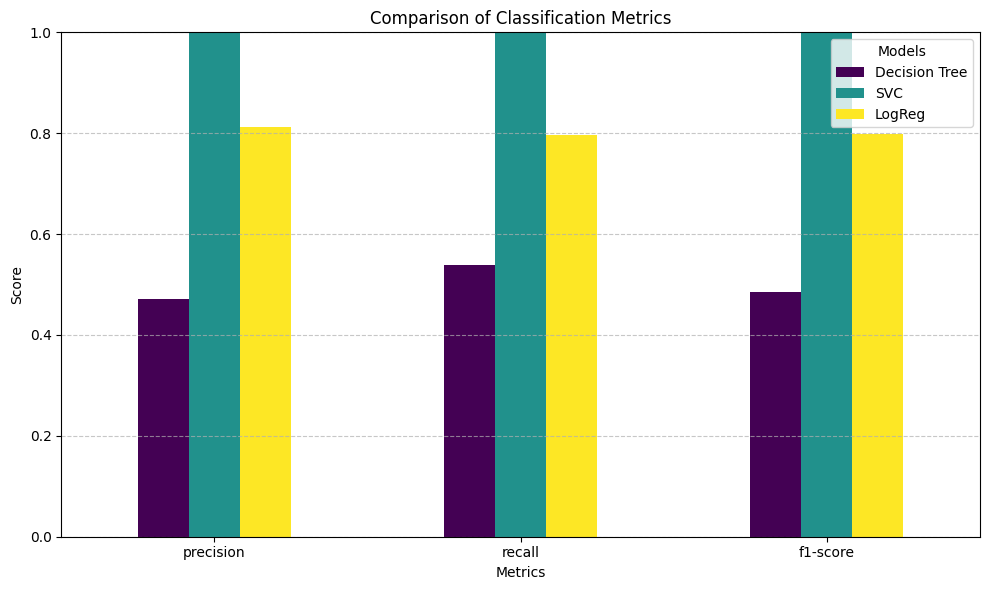

In [ ]:
import matplotlib.pyplot as plt

report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df_plot = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df_plot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Только текстовые признаки

Используем ранее полученные матрицы векторизованного лемматизированного текста.

In [36]:
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train_vect, y_train)
model_logreg.fit(X_train_vect, y_train)
model_dt.fit(X_train_vect, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [37]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test_vect)
y_pred_logreg = model_logreg.predict(X_test_vect)
y_pred_dt = model_dt.predict(X_test_vect)

##### Метрики качества:

###### SVC

In [38]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7602339181286549
Precision: 0.7642036190174659
Recall: 0.7602339181286549
F1 Score: 0.7541405557565779
Confusion Matrix:
 [[16  1  0  0  0  1  2  0  0  0  0  0  1]
 [ 3 38  0  1  0  1  4  0  1  0  0  1  1]
 [ 1  2 29  1  1  2  0  0  1  1  0  0  0]
 [ 2  2  3 29  0  3  2  0  2  0  2  0  0]
 [ 2  0  0  0 10  0  1  0  0  0  0  0  0]
 [ 1  0  1  0  1 50  0  0  2  1  0  3  0]
 [ 0  3  0  0  0  0 71  0  2  1  0  0  1]
 [ 1  0  1  0  0  0  2  1  1  1  0  0  0]
 [ 0  0  0  2  0  0  1  0 47  0  1  2  0]
 [ 1  1  1  2  1  0  0  0  0 21  0  1  0]
 [ 1  3  0  1  0  0  0  0  0  0 30  1  0]
 [ 1  1  4  2  2  0  6  0  1  3  0 40  1]
 [ 3  2  0  2  0  1  5  1  0  2  0  0  8]]


In [39]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.50      0.76      0.60        21
            Бунин Иван Алексеевич       0.72      0.76      0.74        50
        Гоголь Николай Васильевич       0.74      0.76      0.75        38
     Достоевский Федор Михайлович       0.72      0.64      0.68        45
      Есенин Сергей Александрович       0.67      0.77      0.71        13
      Карамзин Николай Михайлович       0.86      0.85      0.85        59
        Куприн Александр Иванович       0.76      0.91      0.83        78
         Лермонтов Михаил Юрьевич       0.50      0.14      0.22         7
 Мамин-Сибиряк Дмитрий Наркисович       0.82      0.89      0.85        53
       Пушкин Александр Сергеевич       0.70      0.75      0.72        28
Салтыков-Щедрин Михаил Евграфович       0.91      0.83      0.87        36
          Тургенев Иван Сергеевич       0.83      0.66      0.73        61


###### LogisticRegression

In [40]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8382066276803118
Precision: 0.8404240675783091
Recall: 0.8382066276803118
F1 Score: 0.8368036264177879
Confusion Matrix:
 [[13  0  0  0  1  1  4  0  0  1  0  0  1]
 [ 1 42  0  1  0  2  2  0  1  0  0  0  1]
 [ 0  1 30  1  0  2  0  0  0  3  0  1  0]
 [ 0  1  3 31  0  2  5  0  1  0  1  1  0]
 [ 2  0  0  0 10  0  1  0  0  0  0  0  0]
 [ 0  0  2  0  1 53  0  0  0  1  0  2  0]
 [ 0  1  0  0  0  0 75  1  0  0  0  0  1]
 [ 0  0  1  0  0  0  2  3  0  0  0  1  0]
 [ 0  1  0  1  0  0  2  0 48  0  0  0  1]
 [ 0  1  1  1  0  0  0  1  0 24  0  0  0]
 [ 0  1  0  2  0  0  0  0  0  0 33  0  0]
 [ 0  0  1  1  1  0  3  0  0  2  0 51  2]
 [ 1  2  0  1  0  0  1  1  0  1  0  0 17]]


In [41]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.76      0.62      0.68        21
            Бунин Иван Алексеевич       0.84      0.84      0.84        50
        Гоголь Николай Васильевич       0.79      0.79      0.79        38
     Достоевский Федор Михайлович       0.79      0.69      0.74        45
      Есенин Сергей Александрович       0.77      0.77      0.77        13
      Карамзин Николай Михайлович       0.88      0.90      0.89        59
        Куприн Александр Иванович       0.79      0.96      0.87        78
         Лермонтов Михаил Юрьевич       0.50      0.43      0.46         7
 Мамин-Сибиряк Дмитрий Наркисович       0.96      0.91      0.93        53
       Пушкин Александр Сергеевич       0.75      0.86      0.80        28
Салтыков-Щедрин Михаил Евграфович       0.97      0.92      0.94        36
          Тургенев Иван Сергеевич       0.91      0.84      0.87        61


###### DecisionTreeClassifier

In [42]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5048732943469786
Precision: 0.539558021409738
Recall: 0.5048732943469786
F1 Score: 0.4491389308933816
Confusion Matrix:
 [[ 0 14  0  0  0  2  5  0  0  0  0  0  0]
 [ 1 35  0  0  0  4 10  0  0  0  0  0  0]
 [ 1  3  0  0  0  6 24  0  0  0  0  4  0]
 [ 2  6  1  2  0  3 29  0  0  0  0  1  1]
 [ 0  1  0  0  0  3  9  0  0  0  0  0  0]
 [ 0  5  0  0  0 39 13  0  0  0  0  1  1]
 [ 0  0  0  0  0  4 74  0  0  0  0  0  0]
 [ 0  2  0  0  0  1  4  0  0  0  0  0  0]
 [ 0  1  0  0  0  1 19  0 31  0  1  0  0]
 [ 1  6  0  0  0  6 12  0  0  0  1  2  0]
 [ 1  0  0  0  0  0  5  0  0  0 28  2  0]
 [ 0  4  1  0  0  2 18  0  0  0  1 35  0]
 [ 0  0  0  0  0  2  5  0  0  0  0  2 15]]


In [43]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.45      0.70      0.55        50
        Гоголь Николай Васильевич       0.00      0.00      0.00        38
     Достоевский Федор Михайлович       1.00      0.04      0.09        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       0.53      0.66      0.59        59
        Куприн Александр Иванович       0.33      0.95      0.49        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      0.58      0.74        53
       Пушкин Александр Сергеевич       0.00      0.00      0.00        28
Салтыков-Щедрин Михаил Евграфович       0.90      0.78      0.84        36
          Тургенев Иван Сергеевич       0.74      0.57      0.65        61


##### Сводка по метрикам качества

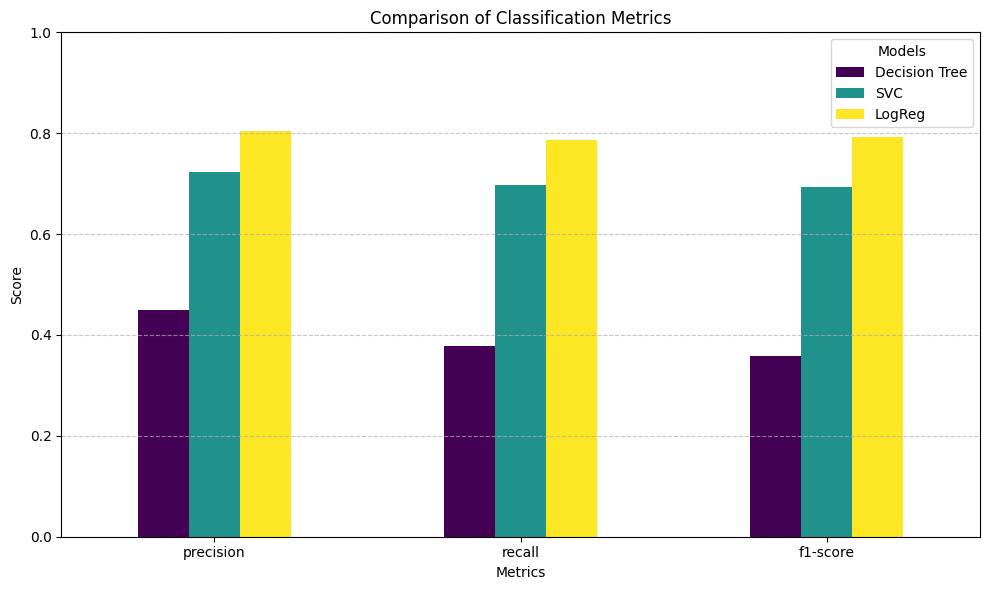

In [44]:
import matplotlib.pyplot as plt

report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df_plot = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df_plot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Эвристики + текстовые признаки

Стоит отметить, что эвиристики и текстовые признаки векторизации имеют разную природу. Это значит, что при необходимости стандартизации нужно рассматривать наборы фичей отдельно.

In [ ]:
X_heur_train, X_heur_test, X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_heuristics, X_bow, y, test_size=0.2, random_state=42)

In [ ]:
# Стандартизация эвристик
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_heur_train)
X_test_scaled = scaler.transform(X_heur_test)

In [ ]:
# Формирование итоговых датасетов
X_train_combined = np.hstack([X_train_scaled, X_bow_train.toarray()])
X_test_combined = np.hstack([X_test_scaled, X_bow_test.toarray()])

In [ ]:
X_train_combined.shape

(2052, 504)

Теперь у нас $4$ эвристики и $500$ текстовых фичей.

In [ ]:
# Инициализация и обучение моделей
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train_combined, y_train)
model_logreg.fit(X_train_combined, y_train)
model_dt.fit(X_train_combined, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test_combined)
y_pred_logreg = model_logreg.predict(X_test_combined)
y_pred_dt = model_dt.predict(X_test_combined)

##### Метрики качества:

###### SVC

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8245614035087719
Precision: 0.8471696614088091
Recall: 0.8245614035087719
F1 Score: 0.8305615174248677
Confusion Matrix:
 [[12  2  0  0  1  0  4  0  0  0  1  0  1]
 [ 4 41  0  0  1  0  1  0  1  0  2  0  0]
 [ 7  1 25  0  0  0  1  1  0  0  2  1  0]
 [ 0  0  0 36  0  0  2  1  0  0  4  2  0]
 [ 0  2  0  0  7  0  2  0  0  1  0  0  1]
 [ 2  0  0  0  0 54  0  1  2  0  0  0  0]
 [ 2  3  0  0  1  0 69  2  1  0  0  0  0]
 [ 1  1  0  0  0  0  0  4  1  0  0  0  0]
 [ 0  0  0  1  0  0  3  0 48  0  1  0  0]
 [ 2  2  0  0  1  0  0  0  0 23  0  0  0]
 [ 0  1  0  0  1  0  1  0  0  0 32  1  0]
 [ 3  0  1  1  0  0  0  1  1  0  0 54  0]
 [ 0  2  0  0  0  0  1  0  0  2  1  0 18]]


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.36      0.57      0.44        21
            Бунин Иван Алексеевич       0.75      0.82      0.78        50
        Гоголь Николай Васильевич       0.96      0.66      0.78        38
     Достоевский Федор Михайлович       0.95      0.80      0.87        45
      Есенин Сергей Александрович       0.58      0.54      0.56        13
      Карамзин Николай Михайлович       1.00      0.92      0.96        59
        Куприн Александр Иванович       0.82      0.88      0.85        78
         Лермонтов Михаил Юрьевич       0.40      0.57      0.47         7
 Мамин-Сибиряк Дмитрий Наркисович       0.89      0.91      0.90        53
       Пушкин Александр Сергеевич       0.88      0.82      0.85        28
Салтыков-Щедрин Михаил Евграфович       0.74      0.89      0.81        36
          Тургенев Иван Сергеевич       0.93      0.89      0.91        61


###### LogisticRegression

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8635477582846004
Precision: 0.8691767442462354
Recall: 0.8635477582846004
F1 Score: 0.8646268448520311
Confusion Matrix:
 [[14  2  0  0  3  1  1  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  6  0  1  0  0  0  1]
 [ 1  0 33  0  1  1  0  1  0  0  0  1  0]
 [ 0  0  0 38  0  0  1  1  0  0  3  2  0]
 [ 0  1  0  0  8  0  3  0  0  0  0  0  1]
 [ 1  0  0  1  0 56  0  1  0  0  0  0  0]
 [ 1  3  0  0  0  0 72  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  5  0  0  0  0  1]
 [ 1  0  0  1  0  0  3  0 47  0  1  0  0]
 [ 0  0  0  0  0  0  1  1  0 25  1  0  0]
 [ 0  0  0  2  0  0  1  0  0  0 32  1  0]
 [ 2  1  1  0  0  1  0  0  0  0  1 55  0]
 [ 0  2  1  0  0  0  2  0  0  2  0  0 17]]


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.70      0.67      0.68        21
            Бунин Иван Алексеевич       0.82      0.82      0.82        50
        Гоголь Николай Васильевич       0.94      0.87      0.90        38
     Достоевский Федор Михайлович       0.90      0.84      0.87        45
      Есенин Сергей Александрович       0.62      0.62      0.62        13
      Карамзин Николай Михайлович       0.95      0.95      0.95        59
        Куприн Александр Иванович       0.79      0.92      0.85        78
         Лермонтов Михаил Юрьевич       0.50      0.71      0.59         7
 Мамин-Сибиряк Дмитрий Наркисович       0.98      0.89      0.93        53
       Пушкин Александр Сергеевич       0.93      0.89      0.91        28
Салтыков-Щедрин Михаил Евграфович       0.84      0.89      0.86        36
          Тургенев Иван Сергеевич       0.93      0.90      0.92        61


###### DecisionTreeClassifier

In [ ]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7485380116959064
Precision: 0.6800870353271091
Recall: 0.7485380116959064
F1 Score: 0.6965201375213945
Confusion Matrix:
 [[ 0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.24      1.00      0.38        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       0.00      0.00      0.00        28
Салтыков-Щедрин Михаил Евграфович       0.00      0.00      0.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


##### Сводка по метрикам качества

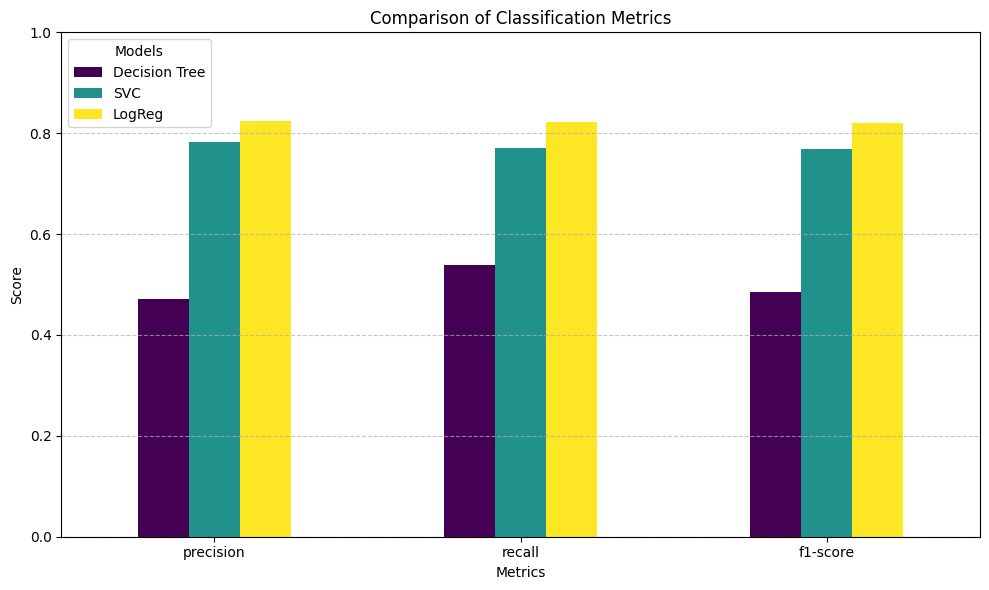

In [ ]:
report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df_plot = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df_plot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()